In [ ]:
from google.colab import drive
from google.colab import files

import re
import pandas as pd
import numpy as np
import yfinance as yf
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math


from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification


plt.style.use('seaborn-whitegrid')
pd.options.display.max_columns = None

<ipython-input-3-9baec8ca1cbf>:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
def contains_irrelevant_hashtags(hashtags_list, irrelevant_hashtags):
    lowercase_hashtags = [hashtag.lower() for hashtag in hashtags_list]
    lowercase_irrelevant_hashtags = [hashtag.lower() for hashtag in irrelevant_hashtags]
    return any(hashtag in lowercase_hashtags for hashtag in lowercase_irrelevant_hashtags)


def extract_hashtags(s):
    return re.findall(r'\#\w+', s)

def filter_by_hashtag(df, hashtag):
    # Convert the hashtags in the DataFrame to lowercase
    df['hashtags_lower'] = df['hashtags'].apply(lambda x: [tag.lower() for tag in x])
    # Convert the input hashtag to lowercase
    hashtag_lower = hashtag.lower()
    # Create a boolean mask to filter rows that contain the lowercase hashtag
    mask = df['hashtags_lower'].apply(lambda x: hashtag_lower in x)
    # Apply the mask to the DataFrame to get the subset
    subset = df[mask]

    return subset


# Function to get sentiment scores using VADER
def get_sentiment_scores(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

def create_sentiment_df(df, column):
    tqdm.pandas()
    sentiment_df = df[column].progress_apply(get_sentiment_scores)
    sentiment_df = pd.DataFrame(sentiment_df.tolist())[['compound']]
    sentiment_df.columns = ['sentiment']
    return sentiment_df


# Check if the tweet contains spam keywords
def contains_spam_keywords(text):
    for keyword in spam_keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', text, flags=re.IGNORECASE):
            return True
    return False

def contains_repetitive_words(text):
    tokens = word_tokenize(text.lower())
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in stopwords_set]
    unique_tokens = set(stemmed_tokens)
    return len(unique_tokens) < len(stemmed_tokens)

# Detect spam text
# Check for excessive use of punctuation marks
def contains_excessive_punctuation(text):
    count = sum(1 for char in text if char in string.punctuation)
    return count > len(text) * 0.1  # Adjust the threshold as needed

# Check for all uppercase or all lowercase text
def is_all_uppercase_or_lowercase(text):
    return text.isupper() or text.islower()

# Check for repeated characters or sequences
def contains_repeated_characters(text):
    return re.search(r'(.)\1{2,}', text) is not None

# Check for URLs or email addresses
def contains_urls_or_emails(text):
    return re.search(r'(https?|ftp)://[^\s/$.?#].[^\s]*|[\w.-]+@[\w.-]+.\w+', text) is not None

# Detect spam text using multiple filters
def detect_spam(tweet):
    if contains_spam_keywords(tweet['body']):
        return True

    if contains_repetitive_words(tweet['body']):
        return True

    if contains_excessive_punctuation(tweet['body']):
        return True

    if is_all_uppercase_or_lowercase(tweet['body']):
        return True

    if contains_repeated_characters(tweet['body']):
        return True

    if contains_urls_or_emails(tweet['body']):
        return True

    return False


def invert_predictions(model, scaler, trainX, trainY, testX, testY):

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # Invert predictions for training data
    trainPredict = scaler.inverse_transform(np.hstack((trainPredict, np.zeros((trainPredict.shape[0], 1)))))[:, 0]
    trainY = scaler.inverse_transform(np.hstack((trainY.reshape(-1, 1), np.zeros((trainY.shape[0], 1)))))[:, 0]

    # Invert predictions for testing data
    testPredict = scaler.inverse_transform(np.hstack((testPredict, np.zeros((testPredict.shape[0], 1)))))[:, 0]
    testY = scaler.inverse_transform(np.hstack((testY.reshape(-1, 1), np.zeros((testY.shape[0], 1)))))[:, 0]

    return trainY, trainPredict, testY, testPredict

# Calculate Mean Absolute Percentage Error GRID
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100


def calculate_r_squared(y_true, y_pred):
    """
    Calculate R-squared (R2) metric for regression model.

    Parameters:
        y_true (numpy array): Array of true target values.
        y_pred (numpy array): Array of predicted target values.

    Returns:
        float: R-squared (R2) score.
    """
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def calculate_mean_bias_deviation(y_true, y_pred):
    """
    Calculate Mean Bias Deviation (MBD) metric for regression model.

    Parameters:
        y_true (numpy array): Array of true target values.
        y_pred (numpy array): Array of predicted target values.

    Returns:
        float: Mean Bias Deviation (MBD) score.
    """
    mbd = np.mean(y_pred - y_true)
    return mbd


# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def preprocess_data(df, look_back=10, train_ratio=0.80):
    # Convert DataFrame into matrix
    dataset = df.values
    dataset = dataset.astype('float32')

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Split into train and test sets
    train_size = int(len(dataset) * train_ratio)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    # Reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    return trainX, trainY, testX, testY, scaler

# Function to create model, required for KerasRegressor
def create_model(neurons, dropout_rate):
    model = Sequential()
    model.add(GRU(neurons, input_shape=(1, trainX.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    return model


def plot_predictions(trainY, trainPredict, title):
    plt.figure(figsize=(12, 7))
    plt.title(title, fontsize=18)

    # Define custom colors with better color scheme
    actual_color = '#85C0F9'  # Soft blue for actual
    pred_color = '#FF8482'    # Soft red for predicted

    # Plot actual and predicted values with custom colors and alpha
    plt.plot(trainY, color=actual_color, label='Actual', linewidth=2)
    plt.plot(trainPredict, color=pred_color, label='Predicted', linewidth=2)

    # Add labels and legend
    plt.xlabel('Time Step', fontsize=14)
    plt.ylabel('Normalized Price', fontsize=14)
    plt.legend(fontsize=12)

    # Add grid lines with reduced alpha
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add a horizontal line at zero for better visibility of values
    plt.axhline(y=0, color='black', linewidth=1, alpha=0.7)

    # Customize tick parameters
    plt.tick_params(axis='both', which='major', labelsize=12)

    # Add annotations for the maximum and minimum values
    max_idx = trainPredict.argmax()
    min_idx = trainPredict.argmin()
    plt.annotate(f'Max: {trainPredict[max_idx]:.2f}', xy=(max_idx, trainPredict[max_idx]),
                 xytext=(max_idx, trainPredict[max_idx] + 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=12, horizontalalignment='right')

    plt.annotate(f'Min: {trainPredict[min_idx]:.2f}', xy=(min_idx, trainPredict[min_idx]),
                 xytext=(min_idx, trainPredict[min_idx] - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=12, horizontalalignment='right')

    # Add a vertical line to indicate the last data point
    plt.axvline(x=len(trainY) - 1, color='gray', linestyle='--', linewidth=1, alpha=0.7)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.show()

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

parquet_path = '/content/drive/My Drive/DDE Final Project/part-00000-959ea3bc-6e91-4a6f-bffa-eb7688dd2e6c-c000.snappy.parquet'

# Read the Parquet file into a DataFrame
df = pd.read_parquet(parquet_path, engine='pyarrow', use_nullable_dtypes=True)

# Explore the data
display(df.head(3))
display(df.tail(3))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,verb,user,inreplyto,link,body,retweetbody,date,postedtime,retweetcount,favoritescount,generator,twitter_lang,year,userLocation,userFriends,userFollowers,userNumTweets,userVerified,userLanguage,userBio,country,countrycode,locality,region,subregion,locationname
0,-712159200,post,-1179232094,None,http://twitter.com/hamel1776/statuses/10011537...,South Africa investigates $80 million bitcoin ...,<NA>,2018-05-28,2018-05-28T17:30:28.000Z,0,0,Twitter Web Client,en,2018,"Maine, USA",2867,1529,205498,False,<NA>,Stand for liberty freedom and equal rights for...,United States,US,<NA>,Maine,<NA>,"Maine, United States"
1,-1735632200,post,-1642658858,None,http://twitter.com/dedramaxx1/statuses/1001165...,Bitcoin Black 3600 AirDrop $36 Value https://t...,<NA>,2018-05-28,2018-05-28T18:18:05.000Z,0,0,Twitter Web Client,en,2018,"Chesapeake, VA",7032,25015,13662,False,<NA>,"Entreprenuer, Cryptocurrency Expert, Gospel Mu...",United States,US,Chesapeake,Virginia,City of Chesapeake,"Chesapeake, Virginia, United States"
2,560828400,post,-631709376,None,http://twitter.com/CoinLook/statuses/100134212...,Asian Cryptocurrency Trading Roundup: Bitcoin ...,<NA>,2018-05-29,2018-05-29T05:59:00.000Z,0,0,Buffer,en,2018,USA,13149,21135,126269,False,<NA>,"Articles on #Bitcoin, #FinTech, Cryptocurrency...",United States,US,<NA>,<NA>,<NA>,United States


,id,verb,user,inreplyto,link,body,retweetbody,date,postedtime,retweetcount,favoritescount,generator,twitter_lang,year,userLocation,userFriends,userFollowers,userNumTweets,userVerified,userLanguage,userBio,country,countrycode,locality,region,subregion,locationname
734071,-674975401,post,1749034986,None,http://twitter.com/centralcomputer/statuses/99...,NVIDIA is developing a budget-friendly GPU. Ac...,<NA>,2018-05-24,2018-05-24T18:03:11.000Z,0,0,Facebook,en,2018,SF Bay Area,198,708,1790,False,<NA>,<NA>,United States,US,Coos Bay,Oregon,Coos County,"Coos Bay, Oregon, United States"
734072,1841507799,post,-626905051,None,http://twitter.com/BitMoneyNews/statuses/99973...,"Bitcoin Value Could Plummet Below $7,000 https...",<NA>,2018-05-24,2018-05-24T19:41:44.000Z,0,0,news updates bitmoney,en,2018,"New York, NY",4654,2293,371,False,<NA>,"Daily Cryptocurrency news, reviews & resources...",United States,US,<NA>,New York,<NA>,"New York, United States"
734073,-1867182601,post,-56294310,None,http://twitter.com/ZaysevB/statuses/9999675988...,Hypercube_Fund: DOJ’s Probe into Bitcoin Price...,<NA>,2018-05-25,2018-05-25T10:57:08.000Z,0,0,IFTTT,en,2018,"Miami, FL",14755,19669,17582,False,<NA>,Analyst. Certified pop culture ninja. Lifelong...,United States,US,Miami,Florida,Miami-Dade County,"Miami, Florida, United States"


In [ ]:
df = df.drop([
    'inreplyto', 'retweetbody', 'userLanguage',
    'subregion', 'region', 'locality'], axis = 1).dropna(subset = ['userLocation']).fillna('')

#Drop the duplicated tweets
df = df[~df['link'].duplicated()].copy(deep = True)

#Drop the duplicated IDs
df = df[~df['id'].duplicated()].copy(deep = True)

#Only taking US located tweets (since the other countries are way less)
df = df[df['country'] == 'United States']

#Converting the datetime objects to their proper dtype
df['date'] = pd.to_datetime(df['date'])
df['postedtime'] = pd.to_datetime(df['postedtime'])

#Create the username column
df.insert(0, 'tweetid', df['link'].str.strip().str.split('/').str[-1].astype('Int64'))
df.insert(1, 'username',df['link'].str.strip().str.extract(r'http://twitter.com/(\w+)/'))
df['time_period'] = df['postedtime'].dt.hour.map({0: 'Night', 1: 'Night', 2: 'Night', 3: 'Night', 4: 'Night',
                                                  5: 'Morning', 6: 'Morning', 7: 'Morning', 8: 'Morning',
                                                  9: 'Morning', 10: 'Morning', 11: 'Morning',
                                                  12: 'Morning', 13: 'Afternoon', 14: 'Afternoon',
                                                  15: 'Afternoon', 16: 'Afternoon', 17: 'Afternoon',
                                                  18: 'Afternoon', 19: 'Evening', 20: 'Evening',
                                                  21: 'Evening', 22: 'Evening', 23: 'Evening'})

df['has_hashtags'] = df['body'].str.contains('#').astype('int')
df['has_link'] = df['body'].str.contains('http').astype('int')
df['userVerified'] = df['userVerified'].astype('int')


#Sort the values based on date
df = df.sort_values('postedtime')
df = df.reset_index(drop = True)

#Droping the columns that had only one unique values (useless)
df = df.drop([
    'verb', 'retweetcount', 'favoritescount', 'twitter_lang',
    'country', 'countrycode', 'id', 'user', 'userLocation', 'link', 'year'], axis = 1)


display(df.head(3))
display(df.tail(3))

<ipython-input-6-c9a31e872160>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


,tweetid,username,body,date,postedtime,generator,userFriends,userFollowers,userNumTweets,userVerified,userBio,locationname,time_period,has_hashtags,has_link
0,947619449816809473,DragonShadowLV,Get #Free #Cryptocurrency at EarnCrypto https:...,2018-01-01,2018-01-01 00:04:17+00:00,Twitter for Android,7220,6397,98569,0,Dragon Shadow Training Group Firearms & Perso...,"Las Vegas, Nevada, United States",Night,1,1
1,947619844924563458,charliedavis,If you sell #Bitcoin on 12/31 will the IRS wan...,2018-01-01,2018-01-01 00:05:51+00:00,Twitter Web Client,1272,1164,2626,0,"Moxey is a currency for barter, 4,000+ US busi...","Baton Rouge, Louisiana, United States",Night,1,0
2,947620612486209537,Hacking_Crypto,As EOS Tops $8 Is the Sun About to Set on Ethe...,2018-01-01,2018-01-01 00:08:54+00:00,hackingcrypto_bot,301,114,945,0,All the latest news and articles from around t...,"San Francisco, California, United States",Night,1,1


,tweetid,username,body,date,postedtime,generator,userFriends,userFollowers,userNumTweets,userVerified,userBio,locationname,time_period,has_hashtags,has_link
709291,1609337215716392961,vidal_world,@TectonicFi announcement tectonic coin the cry...,2022-12-31,2022-12-31 23:54:26+00:00,Twitter Web App,130,32,1568,0,tectonic coin is the future crypto will be the...,"New York, United States",Evening,0,1
709292,1609337758811660290,vidal_world,@getMaiar announcement tectonic coin the crypt...,2022-12-31,2022-12-31 23:56:36+00:00,Twitter Web App,130,32,1575,0,tectonic coin is the future crypto will be the...,"New York, United States",Evening,0,1
709293,1609337941725167618,cryptoclickio,🔥 BTCUSD SELL TO 15500❓ Check the post https:/...,2022-12-31,2022-12-31 23:57:20+00:00,Make (formerly Integromat),6624,11688,166326,0,Curated Crypto News - One click away!,"New York, United States",Evening,1,1


In [ ]:
# Apply the function to the 'text' column
df['hashtags'] = df['body'].apply(lambda x: extract_hashtags(x))

irrelevant_hashtags = ['#giveaway', '#airdrop', '#contest', '#sweepstakes',
                       '#win', '#competition', '#free', '#sale', '#discount',
                       '#deal', '#promotion', '#gifts', '#gift', '#affiliatemarketing',
                       '#shopping', '#giftideas', '#freeshipping', '#onlineshopping',
                       '#ad', '#cashapp', '#affiliate', '#deals', '#makemoney', '#discounts'
                      ,'#altcoin', '#altcoin', '#NFT', '#NFTs', '#AxieInfinity', '#Metaverse',
                      '#CashAppDay']

# Create a boolean mask to identify rows with irrelevant hashtags
mask = df['hashtags'].apply(lambda x: any(hashtag in x for hashtag in irrelevant_hashtags))

# Filter out the rows with irrelevant hashtags
df = df[~mask]

df = df[(df['userFollowers'] >= 10)]

df.reset_index(drop = True, inplace=True)


display(df.head(3))
display(df.tail(3))

,tweetid,username,body,date,postedtime,generator,userFriends,userFollowers,userNumTweets,userVerified,userBio,locationname,time_period,has_hashtags,has_link,hashtags
0,947619449816809473,DragonShadowLV,Get #Free #Cryptocurrency at EarnCrypto https:...,2018-01-01,2018-01-01 00:04:17+00:00,Twitter for Android,7220,6397,98569,0,Dragon Shadow Training Group Firearms & Perso...,"Las Vegas, Nevada, United States",Night,1,1,"[#Free, #Cryptocurrency, #MEC, #MCO, #freecoins]"
1,947619844924563458,charliedavis,If you sell #Bitcoin on 12/31 will the IRS wan...,2018-01-01,2018-01-01 00:05:51+00:00,Twitter Web Client,1272,1164,2626,0,"Moxey is a currency for barter, 4,000+ US busi...","Baton Rouge, Louisiana, United States",Night,1,0,[#Bitcoin]
2,947620612486209537,Hacking_Crypto,As EOS Tops $8 Is the Sun About to Set on Ethe...,2018-01-01,2018-01-01 00:08:54+00:00,hackingcrypto_bot,301,114,945,0,All the latest news and articles from around t...,"San Francisco, California, United States",Night,1,1,"[#Blockchain, #ETH]"


,tweetid,username,body,date,postedtime,generator,userFriends,userFollowers,userNumTweets,userVerified,userBio,locationname,time_period,has_hashtags,has_link,hashtags
602592,1609337215716392961,vidal_world,@TectonicFi announcement tectonic coin the cry...,2022-12-31,2022-12-31 23:54:26+00:00,Twitter Web App,130,32,1568,0,tectonic coin is the future crypto will be the...,"New York, United States",Evening,0,1,[]
602593,1609337758811660290,vidal_world,@getMaiar announcement tectonic coin the crypt...,2022-12-31,2022-12-31 23:56:36+00:00,Twitter Web App,130,32,1575,0,tectonic coin is the future crypto will be the...,"New York, United States",Evening,0,1,[]
602594,1609337941725167618,cryptoclickio,🔥 BTCUSD SELL TO 15500❓ Check the post https:/...,2022-12-31,2022-12-31 23:57:20+00:00,Make (formerly Integromat),6624,11688,166326,0,Curated Crypto News - One click away!,"New York, United States",Evening,1,1,"[#bitcoin, #crypto, #btc]"


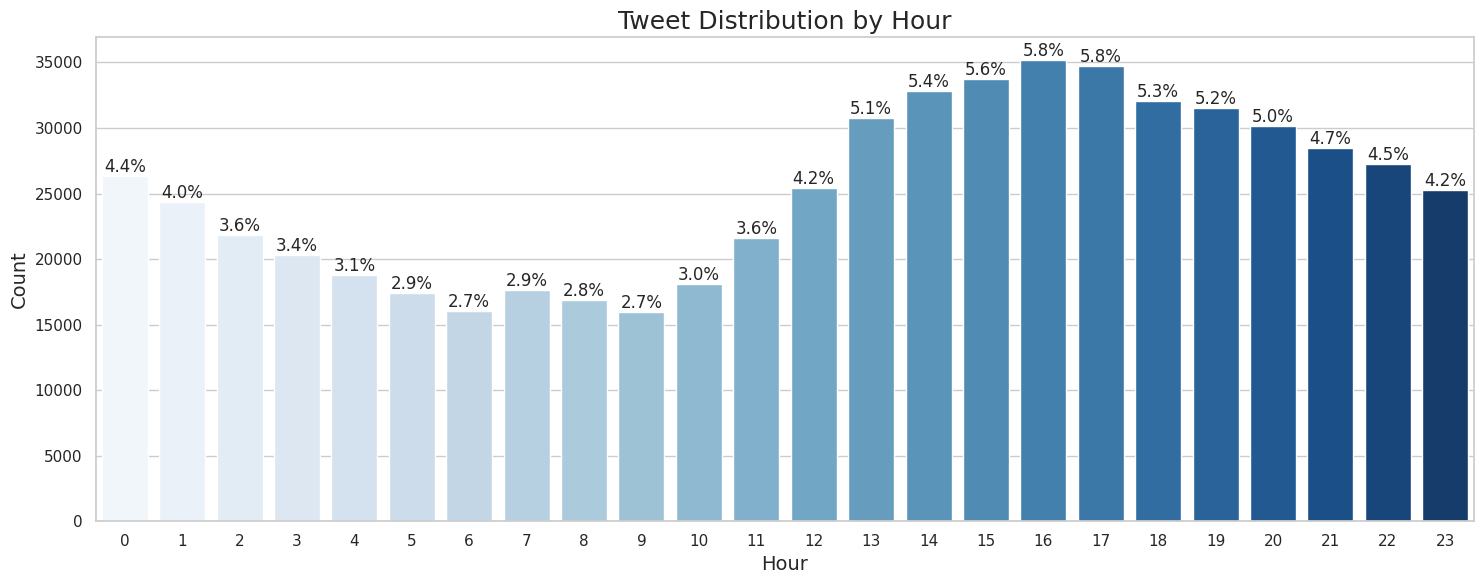

In [ ]:
# Extract the hour from the 'postedtime' column using .loc
df.loc[:, 'hour'] = pd.to_datetime(df['postedtime']).dt.hour

# Count the occurrences of each hour
hour_counts = df['hour'].value_counts().sort_index()

# Calculate the percentage of tweets per hour
total_tweets = len(df)
hour_percentages = (hour_counts / total_tweets) * 100

# Create the bar chart with a professional layout
plt.figure(figsize=(15, 6))
sns.set(style='whitegrid')

# Plot the bar chart using the "Blues" color palette
ax = sns.barplot(x=hour_counts.index, y=hour_counts.values, palette='Blues')

# Customize the chart
ax.set_title('Tweet Distribution by Hour', fontsize=18)
ax.set_xlabel('Hour', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='x', labelrotation=0)

# Add data labels to the bars as percentages
for i, p in enumerate(ax.patches):
    hour = hour_counts.index[i]
    count = p.get_height()
    percentage = hour_percentages.loc[hour]
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12)

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()

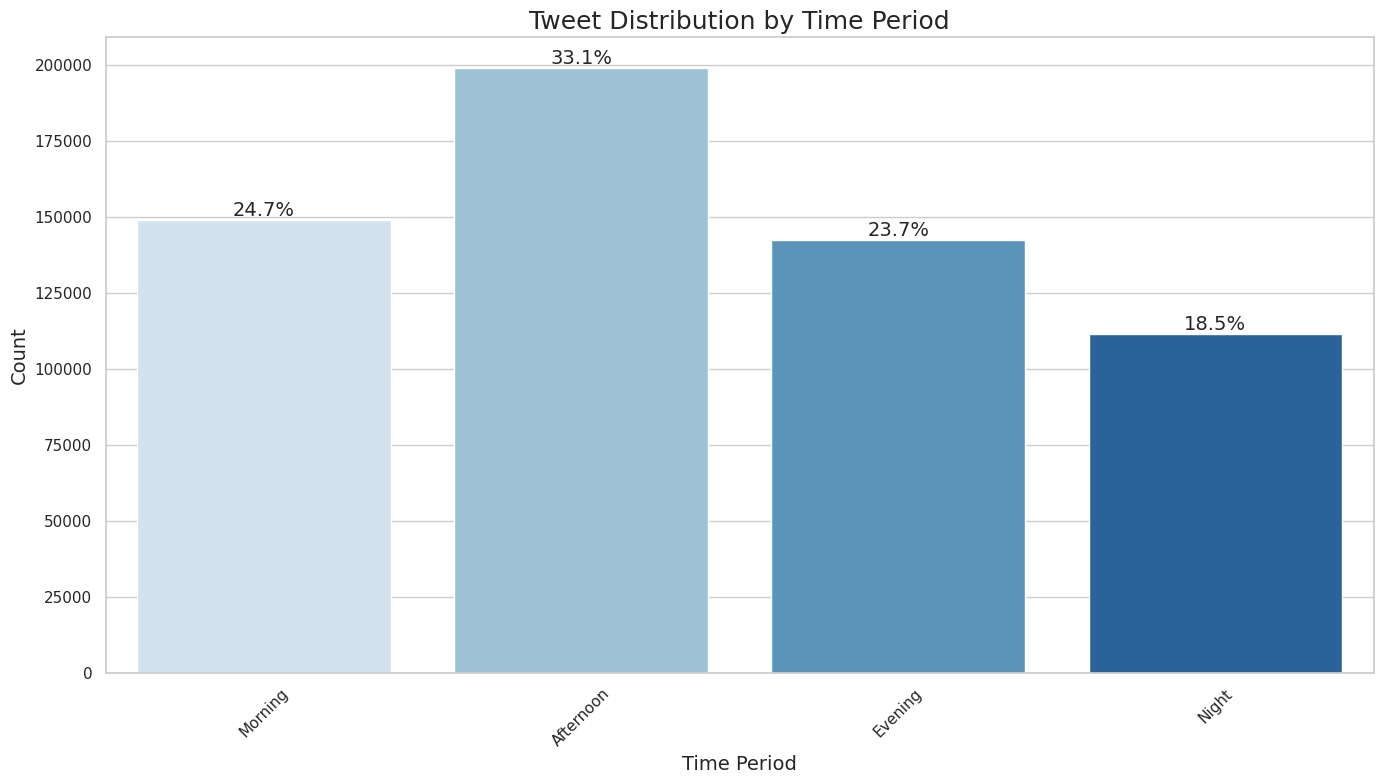

In [ ]:
# Define the desired order of time periods
custom_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Count the occurrences of each time period and sort by the custom order
time_period_counts = df['time_period'].value_counts().loc[custom_order]

# Calculate the percentage of each time period
total_count = time_period_counts.sum()
time_period_percentages = (time_period_counts / total_count) * 100

# Create the bar chart with a professional layout
plt.figure(figsize=(14, 8))
sns.set(style='whitegrid')

# Plot the bar chart
ax = sns.barplot(x=time_period_counts.index, y=time_period_counts.values, palette='Blues')

# Customize the chart
ax.set_title('Tweet Distribution by Time Period', fontsize=18)
ax.set_xlabel('Time Period', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='x', labelrotation=45)

# Add data labels to the bars as percentages
for i, p in enumerate(ax.patches):
    percentage = time_period_percentages.iloc[i]
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=14)

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()

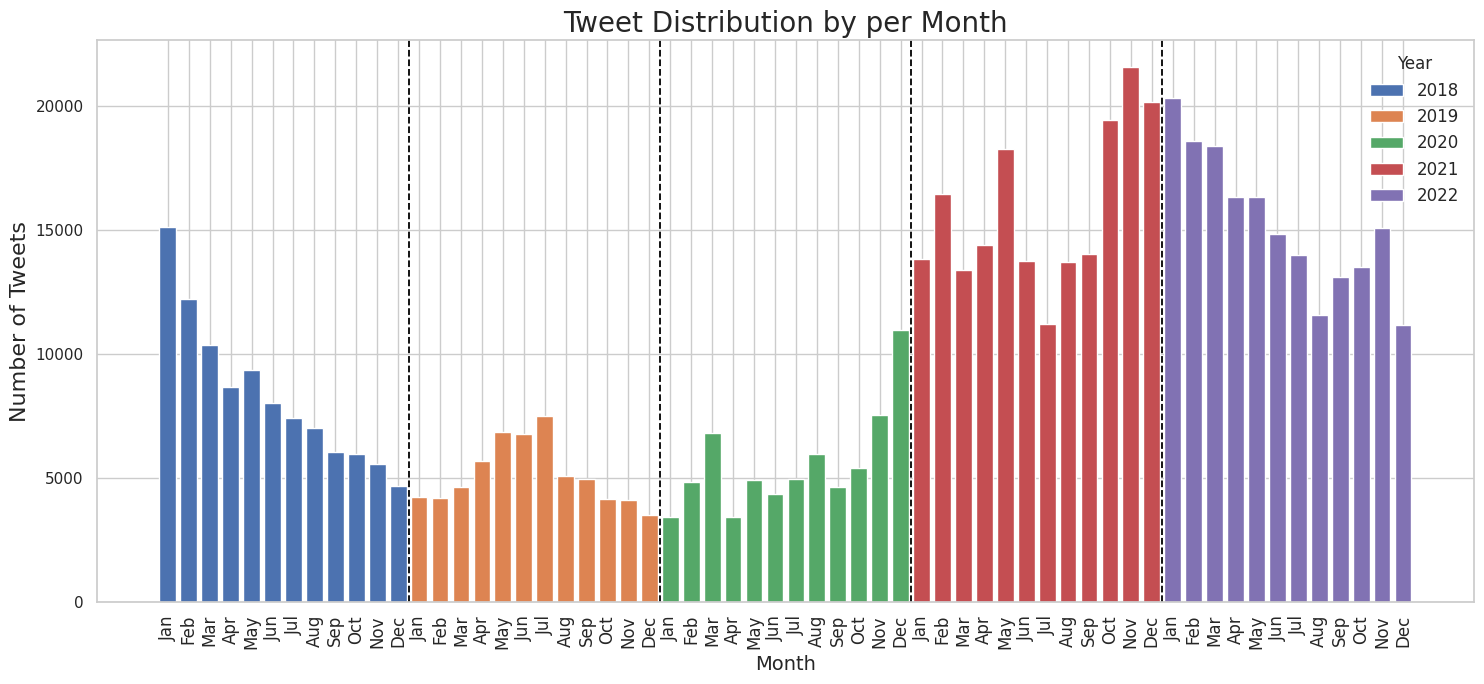

In [ ]:
# Extract year and month from the 'date' column using .loc
df.loc[:, 'year'] = pd.to_datetime(df['postedtime']).dt.year
df.loc[:, 'month'] = pd.to_datetime(df['postedtime']).dt.month

# Group the data by year and month and count the number of rows
monthly_counts = df.groupby(['year', 'month']).size().reset_index(name='count')

# Create a list of month labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Set the figure size
plt.figure(figsize=(15, 7))

# Iterate over each year and plot the bars
for year in monthly_counts['year'].unique():
    year_data = monthly_counts[monthly_counts['year'] == year]
    plt.bar(year_data.index, year_data['count'], label=str(year), width=0.8)

# Set the x-axis ticks and labels
plt.xticks(monthly_counts.index, month_labels * (monthly_counts['year'].nunique()), rotation=90, fontsize = 12)

# Add horizontal lines to divide the years
for year in monthly_counts['year'].unique()[1:]:
    year_index = monthly_counts[monthly_counts['year'] == year].index[0]
    plt.axvline(x=year_index - 0.5, color='black', linewidth=1.3, linestyle='--')

# Set labels, title, and legend
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Number of Tweets', fontsize = 16)
plt.title('Tweet Distribution by per Month', fontsize = 20)
plt.legend(title='Year', fontsize = 12)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df = df.reindex(columns=['username', 'date', 'body', 'hashtags', 'userFollowers'])
df = df[df['body'].apply(lambda x: re.sub(r'#[\w_]+|\W+', ' ', x)).str.strip() != '']
df.reset_index(drop=True, inplace=True)
display(df.head(3))
display(df.tail(3))

,username,date,body,hashtags,userFollowers
0,DragonShadowLV,2018-01-01,Get #Free #Cryptocurrency at EarnCrypto https:...,"[#Free, #Cryptocurrency, #MEC, #MCO, #freecoins]",6397
1,charliedavis,2018-01-01,If you sell #Bitcoin on 12/31 will the IRS wan...,[#Bitcoin],1164
2,Hacking_Crypto,2018-01-01,As EOS Tops $8 Is the Sun About to Set on Ethe...,"[#Blockchain, #ETH]",114


,username,date,body,hashtags,userFollowers
602590,vidal_world,2022-12-31,@TectonicFi announcement tectonic coin the cry...,[],32
602591,vidal_world,2022-12-31,@getMaiar announcement tectonic coin the crypt...,[],32
602592,cryptoclickio,2022-12-31,🔥 BTCUSD SELL TO 15500❓ Check the post https:/...,"[#bitcoin, #crypto, #btc]",11688


In [ ]:
btc_data = yf.download(['BTC-USD'], start='2018-01-02', end='2023-01-01')[['High','Low','Open','Close']]
btc_data

[*********************100%***********************]  1 of 1 completed


,High,Low,Open,Close
Date,,,,
2018-01-02,15444.599609,13163.599609,13625.000000,14982.099609
2018-01-03,15572.799805,14844.500000,14978.200195,15201.000000
2018-01-04,15739.700195,14522.200195,15270.700195,15599.200195
2018-01-05,17705.199219,15202.799805,15477.200195,17429.500000
2018-01-06,17712.400391,16764.599609,17462.099609,17527.000000
...,...,...,...,...
2022-12-27,16959.845703,16642.072266,16919.291016,16717.173828
2022-12-28,16768.169922,16497.556641,16716.400391,16552.572266
2022-12-29,16651.755859,16508.683594,16552.322266,16642.341797


In [ ]:
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

sentiment_df = create_sentiment_df(df, 'body')
sentiment_df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
100%|██████████| 602593/602593 [04:10<00:00, 2406.76it/s]


,sentiment
0,0.0000
1,0.0772
2,0.5106
3,0.0000
4,0.7482


In [ ]:
df = pd.merge(df.merge(btc_data, left_on='date', right_index=True), sentiment_df, left_index=True, right_index=True)
display(df.head())
print(df.shape)

,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment
302,BTCPennyStock,2018-01-02,Easiest way to double your money. Work smarter...,[],538,15444.599609,13163.599609,13625.0,14982.099609,0.8955
303,SachinLulla,2018-01-02,How to protect your Internet of Things devices...,"[#IoT, #InternetOfThings, #IIoT, #IndustrialIo...",35517,15444.599609,13163.599609,13625.0,14982.099609,0.3818
304,cryptolligence,2018-01-02,⬆️ Buy! 🔥 (4:02:37 pm PDT) Price: 13520.00 (+/...,"[#gdax, #coinbase, #btc, #trading, #bitcoin]",178,15444.599609,13163.599609,13625.0,14982.099609,-0.3595
305,TV_TradingIdeas,2018-01-02,Upward Trend Pattern XLM/BTC @ 30m\u2026 $XLM...,[],12031,15444.599609,13163.599609,13625.0,14982.099609,0.0000
306,eagle4942,2018-01-02,"@blacktop buy litecoin on coinbase, transfer l...",[],317,15444.599609,13163.599609,13625.0,14982.099609,-0.2732


(602291, 10)


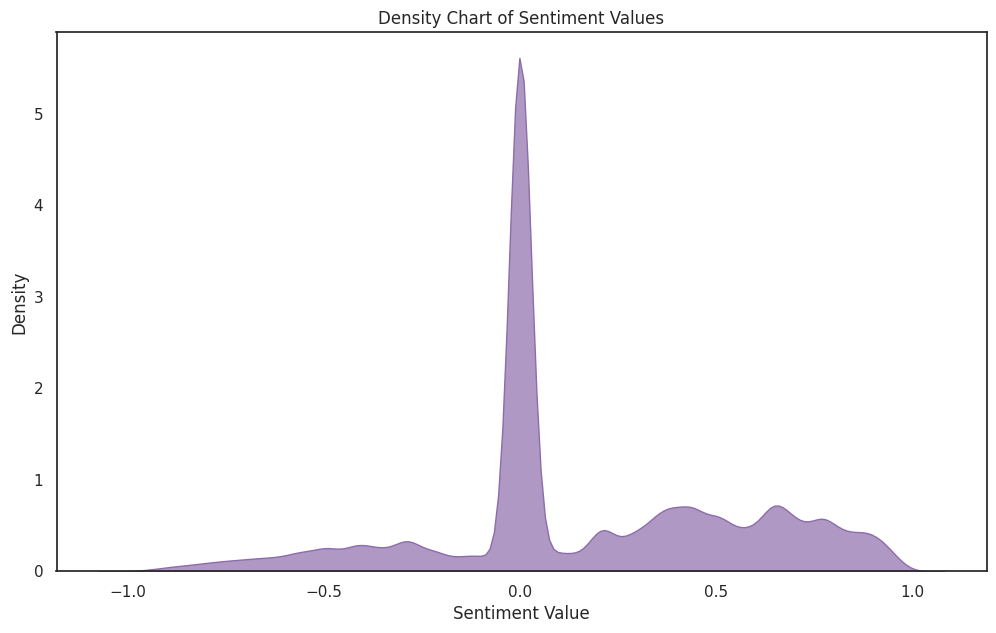

In [ ]:
sns.set(style="white")
plt.figure(figsize=(12, 7))

# Plot the density chart
sns.kdeplot(data=df['sentiment'], fill=True, color="#8d6cab", alpha=0.7)

# Customize the plot
plt.xlabel('Sentiment Value')
plt.ylabel('Density')
plt.title('Density Chart of Sentiment Values')

# Show the plot
plt.show()

In [ ]:
df['sentiment'].describe()

count    602291.000000
mean          0.168392
std           0.396536
min          -0.989900
25%           0.000000
50%           0.000000
75%           0.482400
max           0.996900
Name: sentiment, dtype: float64

In [ ]:
total_strict_zero = sum(df['sentiment'] == 0)
total_strict_zero

230968

In [ ]:
print(f'''Our dataset had a significant degree of imbalance, according to the results of a statistical analysis.
{round(sum(df['sentiment'] == 0) / len(df), 4) * 100}% of the dataset was strictly neutral (sentiment score of 0) even though the sentiment
values were continuous in nature.
The 25 percentile and 50 percentile of the data were strictly zero.
Out of {round(len(df) / 1000, 2)} thousands tweets, {sum(df['sentiment'] == 0) / 1000} thousands tweets were strictly neutral, and more tweets were around this region.''')

Our dataset had a significant degree of imbalance, according to the results of a statistical analysis.
38.35% of the dataset was strictly neutral (sentiment score of 0) even though the sentiment
values were continuous in nature. 
The 25 percentile and 50 percentile of the data were strictly zero. 
Out of 602.29 thousands tweets, 230.968 thousands tweets were strictly neutral, and more tweets were around this region.


To solve this, three operations were implemented as data augmentation:

1. Half of the strictly neutral tweets were removed from the dataset. This section was undersampled to avoid overfitting.

In [ ]:
# Remove the filtered strictly neutral tweets from the dataset
df = df.drop(df[df['sentiment'] == 0].sample(int(total_strict_zero / 2), random_state = 42).index)
display(df.head())

df.info()

,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment
302,BTCPennyStock,2018-01-02,Easiest way to double your money. Work smarter...,[],538,15444.599609,13163.599609,13625.0,14982.099609,0.8955
303,SachinLulla,2018-01-02,How to protect your Internet of Things devices...,"[#IoT, #InternetOfThings, #IIoT, #IndustrialIo...",35517,15444.599609,13163.599609,13625.0,14982.099609,0.3818
304,cryptolligence,2018-01-02,⬆️ Buy! 🔥 (4:02:37 pm PDT) Price: 13520.00 (+/...,"[#gdax, #coinbase, #btc, #trading, #bitcoin]",178,15444.599609,13163.599609,13625.0,14982.099609,-0.3595
306,eagle4942,2018-01-02,"@blacktop buy litecoin on coinbase, transfer l...",[],317,15444.599609,13163.599609,13625.0,14982.099609,-0.2732
308,pass4happiness,2018-01-02,Layman Guide to Cryptocurrency: To buy or Stay...,[],7714,15444.599609,13163.599609,13625.0,14982.099609,0.0000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 486807 entries, 302 to 602591
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   username       486807 non-null  object        
 1   date           486807 non-null  datetime64[ns]
 2   body           486807 non-null  string        
 3   hashtags       486807 non-null  object        
 4   userFollowers  486807 non-null  Int64         
 5   High           486807 non-null  float64       
 6   Low            486807 non-null  float64       
 7   Open           486807 non-null  float64       
 8   Close          486807 non-null  float64       
 9   sentiment      486807 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(5), object(2), string(1)
memory usage: 41.3+ MB


2. Gaussian noise was added to a quarter of the dataset to have lesser strictly neutral data. The added Gaussian noise had a mean of 0 and a standard deviation of 7% of the input signal.

In [ ]:
np.random.seed(42)

# Calculate the number of tweets to add Gaussian noise to
num_noise_tweets = int(0.25 * total_strict_zero)

# Select random tweets for adding Gaussian noise
noise_tweets = df[df['sentiment'] == 0].sample(num_noise_tweets, random_state = 42)

# Calculate the standard deviation for the Gaussian noise
std_dev = 0.07 * df['sentiment'].std()

# Add Gaussian noise with mean 0 and the calculated standard deviation
noise = np.random.normal(0, std_dev, len(noise_tweets))
noise_tweets['sentiment'] += noise

# # Update the dataframe with the modified tweets
df.update(noise_tweets)

display(df.head())
print(f"Now there are {sum(df['sentiment'] == 0)} strictly zero sentiments in the dataframe.")

,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment
302,BTCPennyStock,2018-01-02,Easiest way to double your money. Work smarter...,[],538,15444.599609,13163.599609,13625.0,14982.099609,0.895500
303,SachinLulla,2018-01-02,How to protect your Internet of Things devices...,"[#IoT, #InternetOfThings, #IIoT, #IndustrialIo...",35517,15444.599609,13163.599609,13625.0,14982.099609,0.381800
304,cryptolligence,2018-01-02,⬆️ Buy! 🔥 (4:02:37 pm PDT)\nPrice: 13520.00 (+...,"[#gdax, #coinbase, #btc, #trading, #bitcoin]",178,15444.599609,13163.599609,13625.0,14982.099609,-0.359500
306,eagle4942,2018-01-02,"@blacktop buy litecoin on coinbase, transfer l...",[],317,15444.599609,13163.599609,13625.0,14982.099609,-0.273200
308,pass4happiness,2018-01-02,Layman Guide to Cryptocurrency: To buy or Stay...,[],7714,15444.599609,13163.599609,13625.0,14982.099609,0.046459


Now there are 57742 strictly zero sentiments in the dataframe.


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

# List of keywords associated with spam text
spam_keywords = ['free', 'discount', 'buy now', 'limited time offer', 'exclusive deal']

# Set of common English stopwords
stopwords_set = set(stopwords.words('english'))

# Initialize PorterStemmer for word stemming
stemmer = PorterStemmer()

# Minimum length of the text to be considered non-spam
min_text_length = 20

# Apply spam detection to tweets with a sentiment score of 0
df_temp = df.copy()
df_temp.loc[df_temp['sentiment'] == 0, 'is_spam'] = df_temp[df_temp['sentiment'] == 0].apply(detect_spam, axis=1)

# Remove spam tweets from the dataset
df_temp = df_temp[df_temp['is_spam'] != True]
df_temp.drop('is_spam', axis=1, inplace=True)

df = df_temp.copy()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-28-7f4e8cc8fd91>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop('is_spam', axis=1, inplace=True)


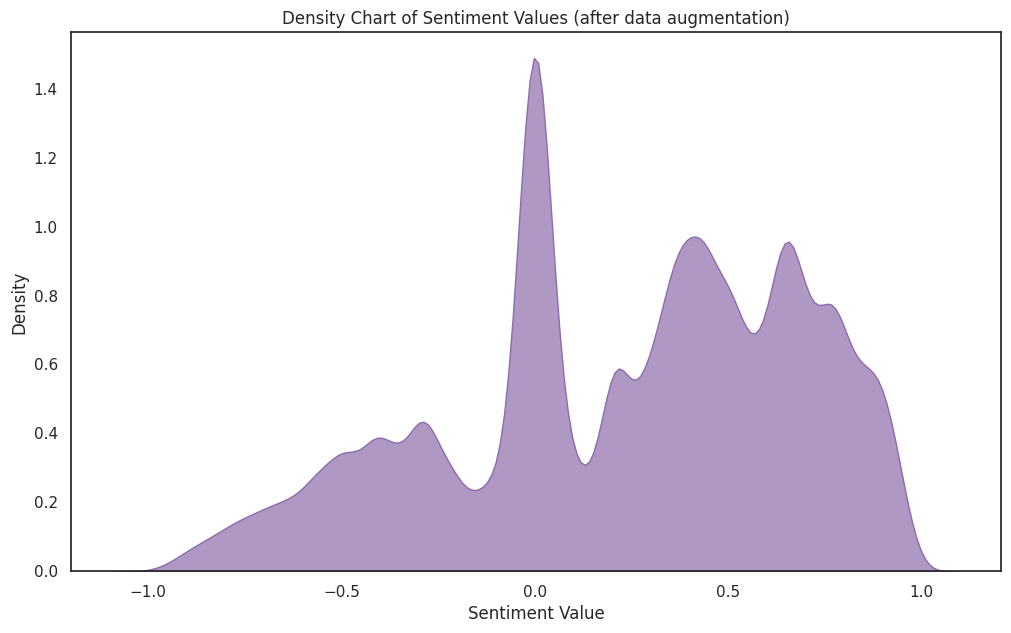

In [ ]:
sns.set(style="white")
plt.figure(figsize=(12, 7))

# Plot the density chart
sns.kdeplot(data=df['sentiment'], fill=True, color="#8d6cab", alpha=0.7)

# Customize the plot
plt.xlabel('Sentiment Value')
plt.ylabel('Density')
plt.title('Density Chart of Sentiment Values (after data augmentation)')

# Show the plot
plt.show()

In [ ]:
display(df.head(3))
display(df.tail(3))

,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment
302,BTCPennyStock,2018-01-02,Easiest way to double your money. Work smarter...,[],538,15444.599609,13163.599609,13625.0,14982.099609,0.8955
303,SachinLulla,2018-01-02,How to protect your Internet of Things devices...,"[#IoT, #InternetOfThings, #IIoT, #IndustrialIo...",35517,15444.599609,13163.599609,13625.0,14982.099609,0.3818
304,cryptolligence,2018-01-02,⬆️ Buy! 🔥 (4:02:37 pm PDT)\nPrice: 13520.00 (+...,"[#gdax, #coinbase, #btc, #trading, #bitcoin]",178,15444.599609,13163.599609,13625.0,14982.099609,-0.3595


,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment
602589,vidal_world,2022-12-31,@cryptocomarena announcement tectonic coin the...,[],32,16628.986328,16517.519531,16603.673828,16547.496094,0.7841
602590,vidal_world,2022-12-31,@TectonicFi announcement tectonic coin the cry...,[],32,16628.986328,16517.519531,16603.673828,16547.496094,0.7841
602591,vidal_world,2022-12-31,@getMaiar announcement tectonic coin the crypt...,[],32,16628.986328,16517.519531,16603.673828,16547.496094,0.7841


# Sentiment Prediction (FinBERT)

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Read the uploaded CSV file
file_path = '/content/drive/My Drive/DDE Final Project/df_processed_augmented.csv'
df = pd.read_csv(file_path, sep = ";", parse_dates=['date'])

# Display the DataFrame
df.head()

Mounted at /content/drive


,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment
0,charliedavis,2018-01-01,If you sell #Bitcoin on 12/31 will the IRS wan...,['#Bitcoin'],1164,14112.200195,13154.700195,14112.200195,13657.200195,0.077200
1,Hacking_Crypto,2018-01-01,As EOS Tops $8 Is the Sun About to Set on Ethe...,"['#Blockchain', '#ETH']",114,14112.200195,13154.700195,14112.200195,13657.200195,0.510600
2,SinCityFinancr,2018-01-01,https://t.co/E0D7biNuKq: Goldman Sachs to Set ...,[],2856,14112.200195,13154.700195,14112.200195,13657.200195,0.041574
3,10minuteexpert,2018-01-01,Bitcoin Cryptocurrency Offer! - 10% Conversion...,[],22665,14112.200195,13154.700195,14112.200195,13657.200195,0.748200
4,block_traders,2018-01-01,#trx finally looks like it may turn around aft...,"['#trx', '#blockchain', '#cryptocurrency', '#t...",30,14112.200195,13154.700195,14112.200195,13657.200195,0.361200


In [ ]:
# Load the FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Specify the class names
class_names = ['negative', 'neutral', 'positive']

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

def predict_sentiment(tweets, batch_size=32):
    # Tokenize all of the sentences and map the tokens to their word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for tweet in tweets:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            max_length = 160,           # Pad & truncate all sentences.
                            padding='max_length',
                            truncation=True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    # Prediction on test set
    print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    predictions = []

    # Predict
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Store predictions and true labels
        predictions.append(logits)

    print('    DONE.')

    flat_predictions = np.concatenate(predictions, axis=0)

    # For each sample, pick the label (0, 1, or 2) with the higher score.
    predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

    # Also get the probabilities
    probabilities = np.exp(flat_predictions) / np.sum(np.exp(flat_predictions), axis=1, keepdims=True)

    return predicted_labels, probabilities

# Apply the function to your tweets
tweets = df['body'].tolist()
predicted_labels, probabilities = predict_sentiment(tweets)

# Map the label IDs to their string labels
predicted_sentiments = [class_names[label] for label in predicted_labels]

# Add the sentiments and probabilities to the dataframe
df['sentiment_FinBert'] = predicted_sentiments
df['probability_FinBert'] = probabilities.max(axis=1)


Predicting labels for 435,521 test sentences...
    DONE.


# GRU Implementation

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Read the uploaded CSV file
file_path = '/content/drive/My Drive/DDE Final Project/df_bert.csv'
df = pd.read_csv(file_path, sep = ";", parse_dates=['date'])
df = df.dropna().reset_index(drop = True)

# Display the DataFrame
display(df.head())
display(df.tail())

,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment,sentiment_FinBert,probability_FinBert
0,charliedavis,2018-01-01,If you sell #Bitcoin on 12/31 will the IRS wan...,['#Bitcoin'],1164.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.077200,positive,0.932753
1,Hacking_Crypto,2018-01-01,As EOS Tops $8 Is the Sun About to Set on Ethe...,"['#Blockchain', '#ETH']",114.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.510600,positive,0.927828
2,SinCityFinancr,2018-01-01,https://t.co/E0D7biNuKq: Goldman Sachs to Set ...,[],2856.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.041574,positive,0.917193
3,10minuteexpert,2018-01-01,Bitcoin Cryptocurrency Offer! - 10% Conversion...,[],22665.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.748200,positive,0.538135
4,block_traders,2018-01-01,#trx finally looks like it may turn around aft...,"['#trx', '#blockchain', '#cryptocurrency', '#t...",30.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.361200,positive,0.826754


,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment,sentiment_FinBert,probability_FinBert
435494,vidal_world,2022-12-31,@cryptocom announcement tectonic coin the cryp...,[],32.0,16628.986328,16517.519531,16603.673828,16547.49609375,0.7841,negative,0.654408
435495,vidal_world,2022-12-31,@DocumentingBTC announcement tectonic coin the...,[],32.0,16628.986328,16517.519531,16603.673828,16547.49609375,0.7841,negative,0.698501
435496,vidal_world,2022-12-31,@cryptocomarena announcement tectonic coin the...,[],32.0,16628.986328,16517.519531,16603.673828,16547.49609375,0.7841,negative,0.695770
435497,vidal_world,2022-12-31,@TectonicFi announcement tectonic coin the cry...,[],32.0,16628.986328,16517.519531,16603.673828,16547.49609375,0.7841,negative,0.688078
435498,vidal_world,2022-12-31,@getMaiar announcement tectonic coin the crypt...,[],32.0,16628.986328,16517.519531,16603.673828,16547.49609375,0.7841,negative,0.694723


In [ ]:
df['sentiment_FinBert_norm'] = df['probability_FinBert'] * df['sentiment_FinBert'].map({'negative': -1, 'neutral': 0, 'positive': 1})
df.head()

,username,date,body,hashtags,userFollowers,High,Low,Open,Close,sentiment,sentiment_FinBert,probability_FinBert,sentiment_FinBert_norm
0,charliedavis,2018-01-01,If you sell #Bitcoin on 12/31 will the IRS wan...,['#Bitcoin'],1164.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.077200,positive,0.932753,0.932753
1,Hacking_Crypto,2018-01-01,As EOS Tops $8 Is the Sun About to Set on Ethe...,"['#Blockchain', '#ETH']",114.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.510600,positive,0.927828,0.927828
2,SinCityFinancr,2018-01-01,https://t.co/E0D7biNuKq: Goldman Sachs to Set ...,[],2856.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.041574,positive,0.917193,0.917193
3,10minuteexpert,2018-01-01,Bitcoin Cryptocurrency Offer! - 10% Conversion...,[],22665.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.748200,positive,0.538135,0.538135
4,block_traders,2018-01-01,#trx finally looks like it may turn around aft...,"['#trx', '#blockchain', '#cryptocurrency', '#t...",30.0,14112.200195,13154.700195,14112.200195,13657.2001953125,0.361200,positive,0.826754,0.826754


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df_finbert = df.groupby(['date', 'Close'], as_index = False)['sentiment_FinBert_norm'].mean().drop('date', axis = 1)

df_finbert.head()

,Close,sentiment_FinBert_norm
0,13657.2001953125,0.743649
1,14982.099609375,0.680327
2,15201.0,0.683126
3,15599.2001953125,0.636568
4,17429.5,0.666644


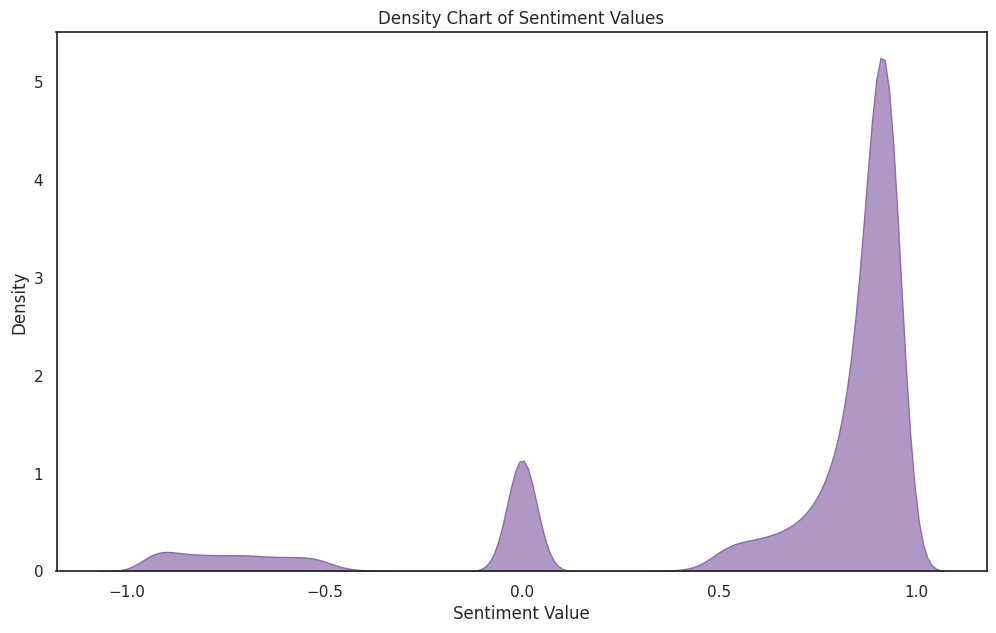

In [ ]:
sns.set(style="white")
plt.figure(figsize=(12, 7))

# Plot the density chart
sns.kdeplot(data=df['sentiment_FinBert_norm'], fill=True, color="#8d6cab", alpha=0.7)

# Customize the plot
plt.xlabel('Sentiment Value')
plt.ylabel('Density')
plt.title('Density Chart of Sentiment Values')

# Show the plot
plt.show()

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df_vader = df.groupby(['date', 'Close'], as_index = False)['sentiment'].mean().drop('date', axis = 1)
#weighted
# df_vader['sentiment'] = (df.groupby('date')['weighted_vader'].sum() / df.groupby('date')['userFollowers'].sum()).values

df_vader.head()

,Close,sentiment
0,13657.2001953125,0.179180
1,14982.099609375,0.238357
2,15201.0,0.243218
3,15599.2001953125,0.098472
4,17429.5,0.142330


# Vader + GRU

In [ ]:
trainX, trainY, testX, testY, scaler = preprocess_data(df_vader)

model = create_model(neurons=32, dropout_rate=0.2)

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
early_stop = EarlyStopping(monitor='val_loss', patience=7)
vader_history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks=[early_stop], validation_split=0.2)

Epoch 1/100
1159/1159 - 10s - loss: 0.0064 - val_loss: 0.0123 - 10s/epoch - 9ms/step
Epoch 2/100
1159/1159 - 6s - loss: 0.0015 - val_loss: 0.0036 - 6s/epoch - 5ms/step
Epoch 3/100
1159/1159 - 5s - loss: 0.0013 - val_loss: 0.0058 - 5s/epoch - 4ms/step
Epoch 4/100
1159/1159 - 3s - loss: 0.0013 - val_loss: 0.0033 - 3s/epoch - 3ms/step
Epoch 5/100
1159/1159 - 6s - loss: 0.0011 - val_loss: 0.0036 - 6s/epoch - 5ms/step
Epoch 6/100
1159/1159 - 4s - loss: 0.0012 - val_loss: 0.0032 - 4s/epoch - 3ms/step
Epoch 7/100
1159/1159 - 3s - loss: 9.4768e-04 - val_loss: 0.0031 - 3s/epoch - 2ms/step
Epoch 8/100
1159/1159 - 3s - loss: 8.3300e-04 - val_loss: 0.0028 - 3s/epoch - 3ms/step
Epoch 9/100
1159/1159 - 3s - loss: 8.1791e-04 - val_loss: 0.0032 - 3s/epoch - 3ms/step
Epoch 10/100
1159/1159 - 7s - loss: 6.3343e-04 - val_loss: 0.0056 - 7s/epoch - 6ms/step
Epoch 11/100
1159/1159 - 3s - loss: 7.4445e-04 - val_loss: 0.0027 - 3s/epoch - 2ms/step
Epoch 12/100
1159/1159 - 3s - loss: 7.8196e-04 - val_loss: 0.00

In [ ]:
# To get the inverted predictions back to their original scale, use the function as follows:
trainY, trainPredict, testY, testPredict = invert_predictions(model, scaler, trainX, trainY, testX, testY)


trainScore = mean_absolute_percentage_error(trainY, trainPredict)
print('Train Score: %.2f MAPE' % (trainScore))
testScore = mean_absolute_percentage_error(testY, testPredict)
print('Test Score: %.2f MAPE' % (testScore))

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# Calculate R-squared (R2)
trainScore = calculate_r_squared(trainY, trainPredict)
print('Train Score: %.4f R2' % (trainScore))
testScore = calculate_r_squared(testY, testPredict)
print('Test Score: %.4f R2' % (testScore))


# Calculate Mean Bias Deviation (MBD)
trainScore = calculate_mean_bias_deviation(trainY, trainPredict)
print('Train Score: %.2f MBD' % (trainScore))
testScore = calculate_mean_bias_deviation(testY, testPredict)
print('Test Score: %.2f MBD' % (testScore))

12/12 [==============================] - 0s 7ms/step
Train Score: 3.35 MAPE
Test Score: 2.81 MAPE
Train Score: 1249.14 RMSE
Test Score: 1197.52 RMSE
Train Score: 0.9951 R2
Test Score: 0.9856 R2
Train Score: -284.29 MBD
Test Score: -254.65 MBD


In [ ]:
# model.load_weights("/content/drive/My Drive/DDE Final Project/gru_model_weights_vader_1.h5")

In [ ]:
# model.save_weights("/content/drive/My Drive/DDE Final Project/gru_model_weights_vader_1.h5")

In [ ]:
# tf.keras.utils.plot_model(model, to_file='gru_model_vader.png', show_shapes=True)

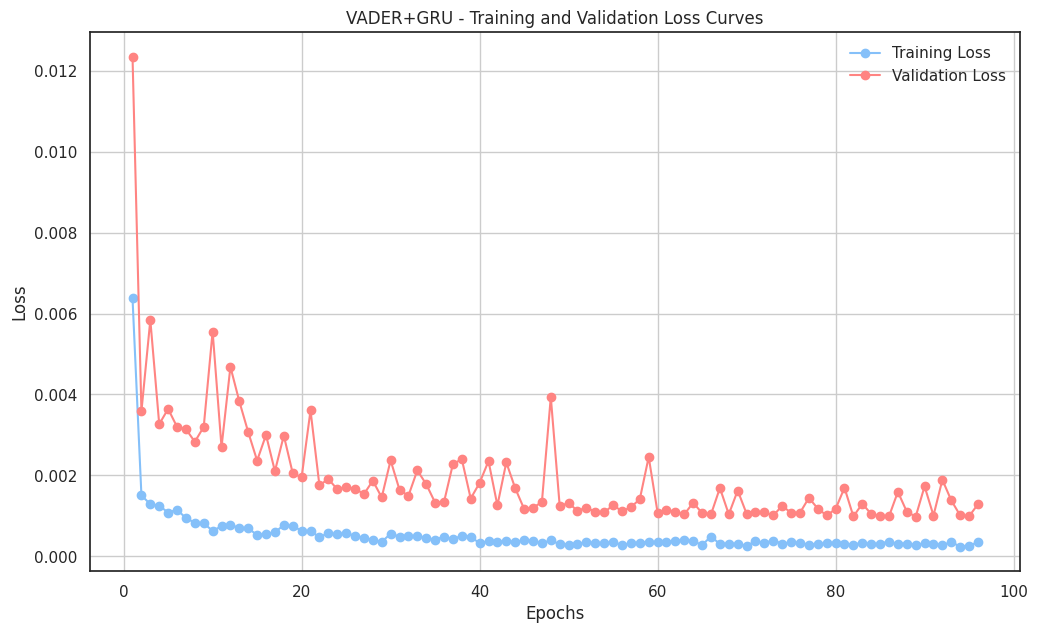

In [ ]:
loss = vader_history.history['loss']
val_loss = vader_history.history['val_loss']
# Create a range of epochs (x-axis for the plot)
epochs = range(1, len(loss) + 1)

# Plot the loss curves
plt.figure(figsize=(12, 7))
plt.plot(epochs, loss, label='Training Loss', color='#85C0F9', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='#FF8482', marker='o')
plt.title('VADER+GRU - Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

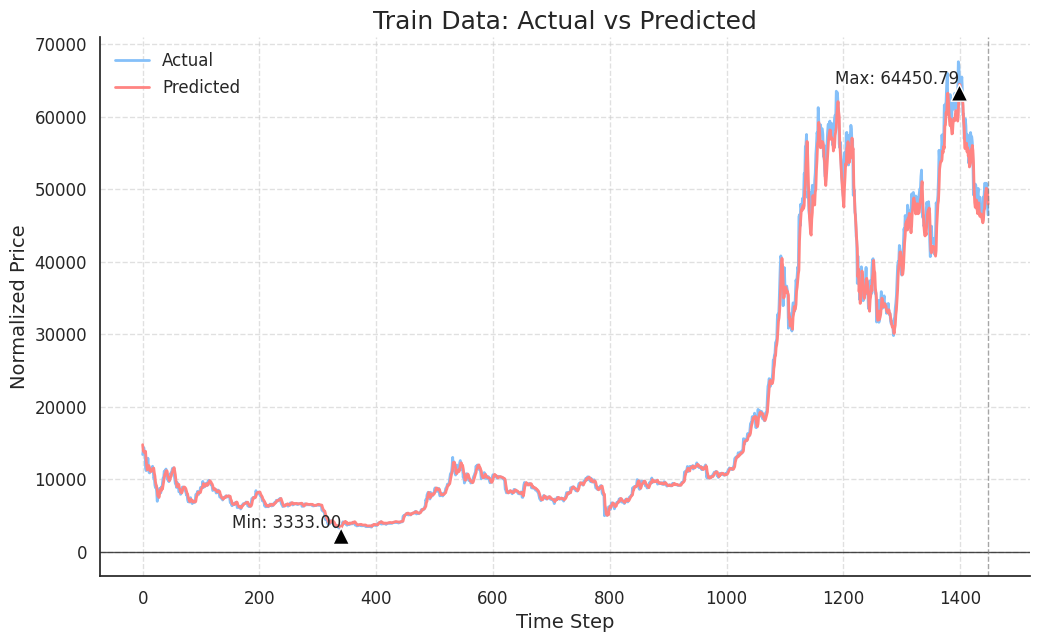

In [ ]:
# Assuming you have 'trainY' and 'trainPredict' from the previous steps
plot_predictions(trainY, trainPredict, title='Train Data: Actual vs Predicted')

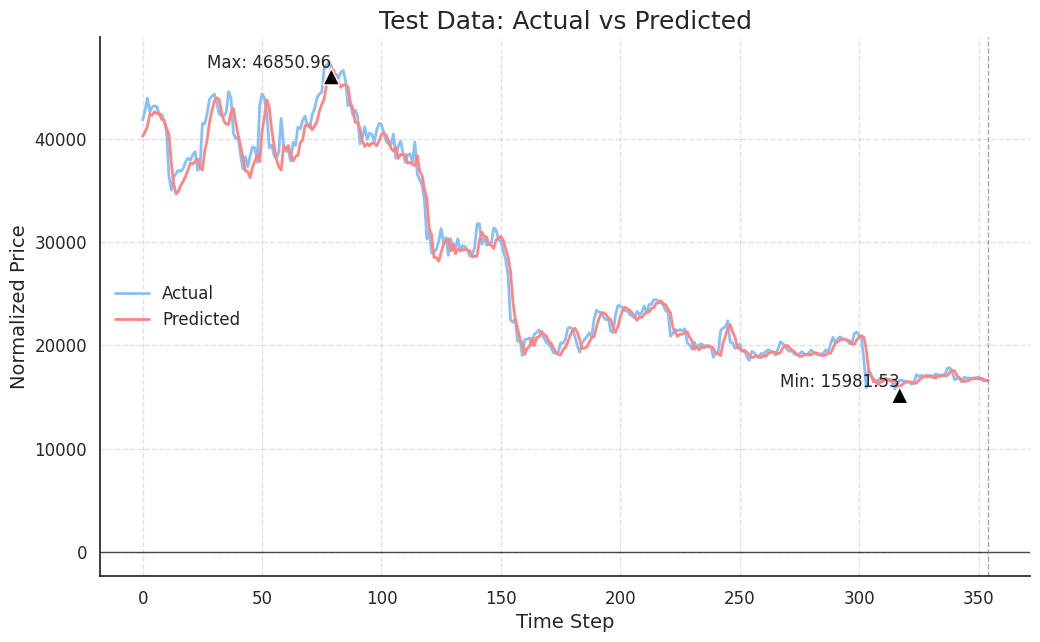

In [ ]:
plot_predictions(testY, testPredict, title='Test Data: Actual vs Predicted')

# Fin-Bert + GRU

In [ ]:
tf.random.set_seed(123)

trainX, trainY, testX, testY, scaler = preprocess_data(df_finbert)

model = create_model(neurons=32, dropout_rate=0.3)

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

# model.load_weights("/content/drive/My Drive/DDE Final Project/gru_model_weights_bert_3.h5")

early_stop = EarlyStopping(monitor='val_loss', patience=7)
bert_history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks=[early_stop], validation_split=0.2)

Epoch 1/100
1159/1159 - 6s - loss: 0.0114 - val_loss: 0.0437 - 6s/epoch - 6ms/step
Epoch 2/100
1159/1159 - 3s - loss: 0.0028 - val_loss: 0.0026 - 3s/epoch - 3ms/step
Epoch 3/100
1159/1159 - 4s - loss: 0.0018 - val_loss: 0.0030 - 4s/epoch - 3ms/step
Epoch 4/100
1159/1159 - 5s - loss: 0.0019 - val_loss: 0.0029 - 5s/epoch - 4ms/step
Epoch 5/100
1159/1159 - 3s - loss: 0.0016 - val_loss: 0.0026 - 3s/epoch - 3ms/step
Epoch 6/100
1159/1159 - 3s - loss: 0.0012 - val_loss: 0.0030 - 3s/epoch - 3ms/step
Epoch 7/100
1159/1159 - 3s - loss: 0.0011 - val_loss: 0.0045 - 3s/epoch - 3ms/step
Epoch 8/100
1159/1159 - 6s - loss: 0.0010 - val_loss: 0.0026 - 6s/epoch - 5ms/step
Epoch 9/100
1159/1159 - 3s - loss: 0.0010 - val_loss: 0.0026 - 3s/epoch - 3ms/step
Epoch 10/100
1159/1159 - 4s - loss: 7.3460e-04 - val_loss: 0.0025 - 4s/epoch - 3ms/step
Epoch 11/100
1159/1159 - 4s - loss: 7.6365e-04 - val_loss: 0.0019 - 4s/epoch - 3ms/step
Epoch 12/100
1159/1159 - 5s - loss: 0.0010 - val_loss: 0.0020 - 5s/epoch - 4m

In [ ]:
# To get the inverted predictions back to their original scale, use the function as follows:
trainY, trainPredict, testY, testPredict = invert_predictions(model, scaler, trainX, trainY, testX, testY)

trainScore = mean_absolute_percentage_error(trainY, trainPredict)
print('Train Score: %.2f MAPE' % (trainScore))
testScore = mean_absolute_percentage_error(testY, testPredict)
print('Test Score: %.2f MAPE' % (testScore))

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# Calculate R-squared (R2)
trainScore = calculate_r_squared(trainY, trainPredict)
print('Train Score: %.4f R2' % (trainScore))
testScore = calculate_r_squared(testY, testPredict)
print('Test Score: %.4f R2' % (testScore))

# Calculate Mean Bias Deviation (MBD)
trainScore = calculate_mean_bias_deviation(trainY, trainPredict)
print('Train Score: %.2f MBD' % (trainScore))
testScore = calculate_mean_bias_deviation(testY, testPredict)
print('Test Score: %.2f MBD' % (testScore))

12/12 [==============================] - 0s 6ms/step
Train Score: 3.46 MAPE
Test Score: 3.07 MAPE
Train Score: 1156.79 RMSE
Test Score: 1286.22 RMSE
Train Score: 0.9958 R2
Test Score: 0.9833 R2
Train Score: 22.43 MBD
Test Score: 407.09 MBD


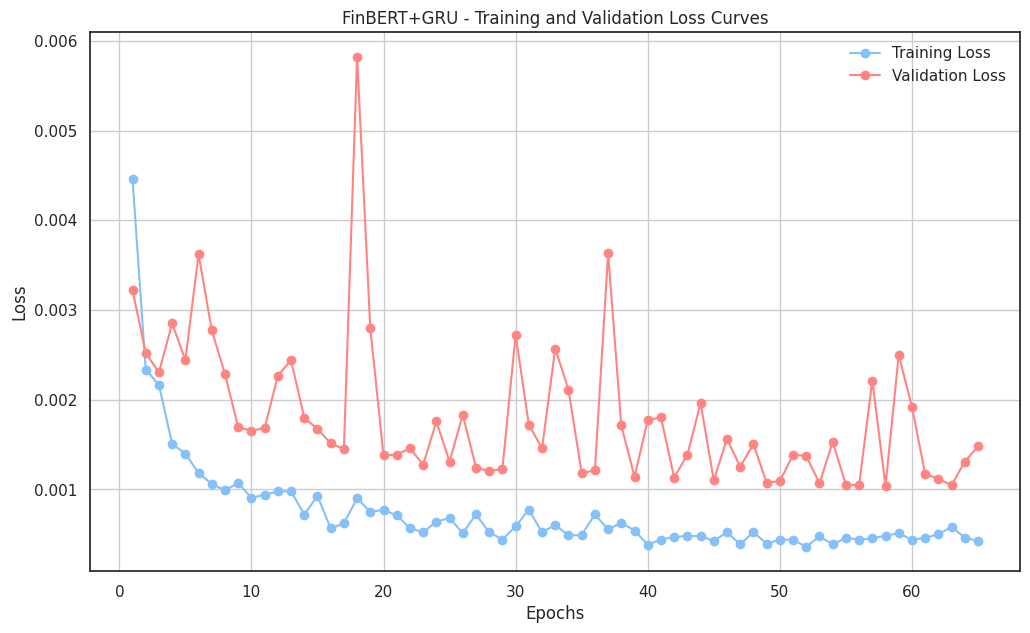

In [ ]:
loss = bert_history.history['loss']#[1:]
val_loss = bert_history.history['val_loss']#[1:]
# Create a range of epochs (x-axis for the plot)
epochs = range(1, len(loss) + 1)

# Plot the loss curves
plt.figure(figsize=(12, 7))
plt.plot(epochs, loss, label='Training Loss', color='#85C0F9', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='#FF8482', marker='o')
plt.title('FinBERT+GRU - Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

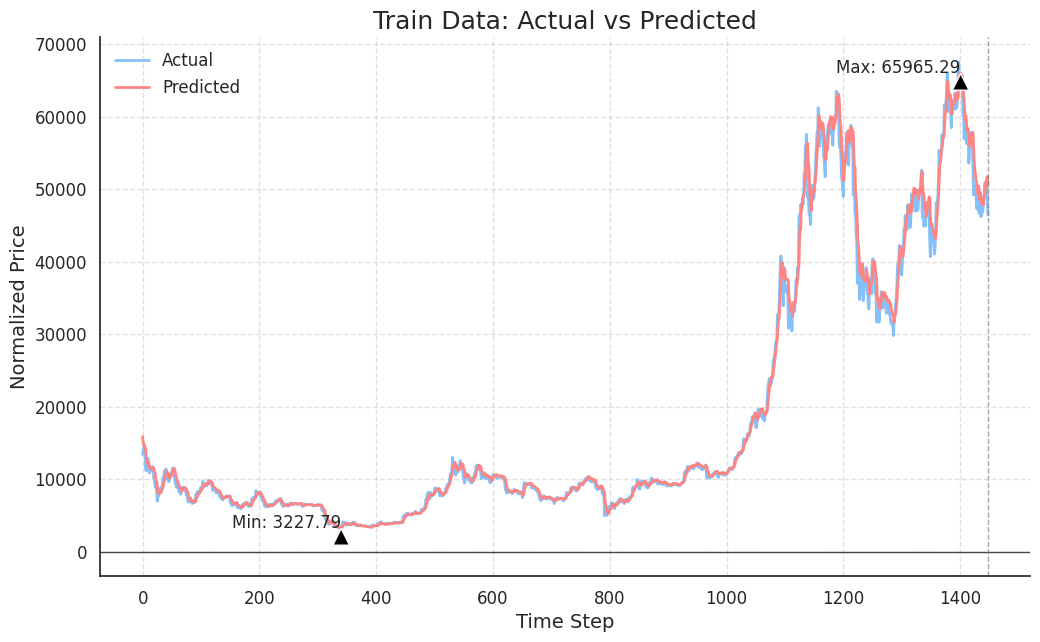

In [ ]:
# Assuming you have 'trainY' and 'trainPredict' from the previous steps
plot_predictions(trainY, trainPredict, title='Train Data: Actual vs Predicted')

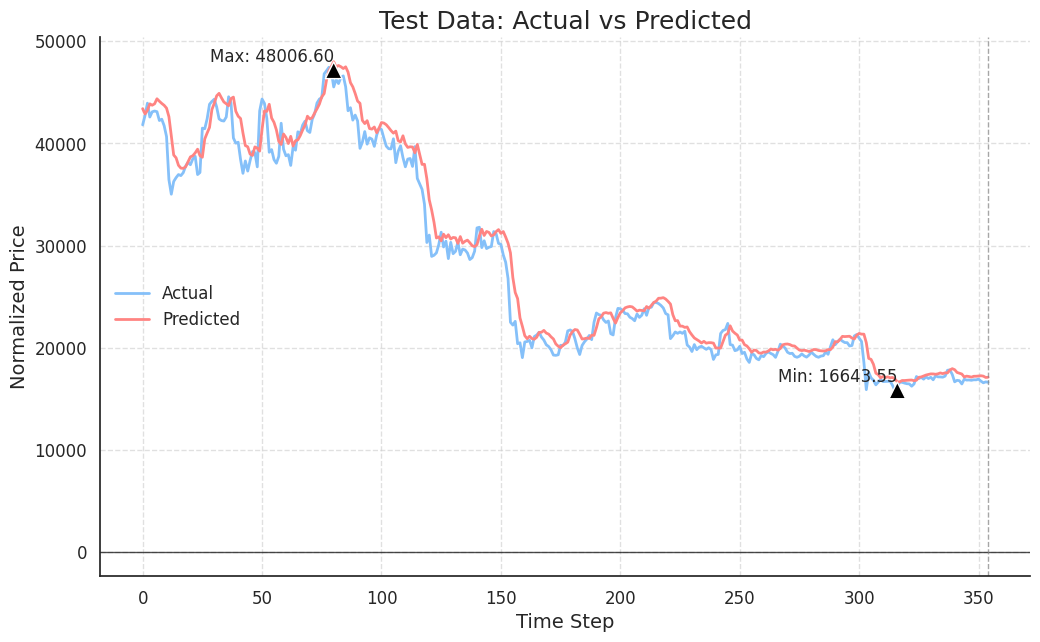

In [ ]:
plot_predictions(testY, testPredict, title='Test Data: Actual vs Predicted')